In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import fsolve

## 1. Define S(Q,t) function

In [2]:
def f_sqt_chain(Q, t, N=100, b=1.0, D=1.0, tau_R=1.0, p_max=10):
    """
    Compute the scattering function S(Q, t) for a Gaussian polymer chain.

    Parameters:
        Q (numpy.ndarray): Scattering vector magnitude (2D array)
        t (numpy.ndarray): Time (2D array)
        N (int): Number of beads in the polymer chain (default 100)
        b (float): Bond length (default 1.0)
        D (float): Diffusion coefficient (default 1.0)
        tau_R (float): Relaxation time (default 1.0)
        p_max (int): Number of terms in the summation for Phi_nm^1 (default 50)

    Returns:
        numpy.ndarray: Value of S(Q, t) (2D array)
    """

    # Indices for polymer beads
    n_values, m_values = np.meshgrid(np.arange(N), np.arange(N))
    abs_nm = np.abs(n_values - m_values)

    # Compute Phi_nm(t) components
    Phi_D = 6 * D * t  # Center-of-mass diffusion
    Phi_nm_0 = abs_nm * b**2  # Gaussian chain contribution

    # Compute Phi_nm^1 (dynamic part)
    Phi_nm_1 = ((4 * N * b**2 / np.pi**2) * 
                np.sum([(1 / p**2) * np.einsum('kl,ij->ijkl', 
                                               np.cos(p * np.pi * n_values / N) * np.cos(p * np.pi * m_values / N), 
                                               (1 - np.exp(-t * p**2 / tau_R))) 
                        for p in range(1, p_max+1)], # sum over p
                       axis=0))
    
    # Total Phi_nm
    Phi_nm = Phi_D[:, :, None, None] + Phi_nm_0[None, None, :, :] + Phi_nm_1
    
    # Compute S(Q, t) using einsum
    Q_squared = Q**2  # Shape [i, j]
    Q_squared_expanded = Q_squared[:, :, None, None]  # Shape [i, j, 1, 1]
    sqt = (1 / N) * np.einsum('ijkl,ijkl->ij', np.exp(- (1/6) * Q_squared_expanded * Phi_nm), np.ones_like(Phi_nm))


    return sqt


## 2. Test visualize S(Q,t)

In [23]:
n_Q = 20
n_t = 20

t = (np.arange(n_t))/n_t*5
b = 0.5
N = 20
D = 0.1
Rg = np.sqrt(N*b**2/6)

QRg = (np.arange(n_Q))/n_Q*5
Q = QRg/Rg

Q_grid, t_grid = np.meshgrid(QRg, t)

sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/n_Q
sq0 = sqt[0, :]

/tmp/ipykernel_3336720/2622157773.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([np.min(QRg), np.max(QRg)])
/tmp/ipykernel_3336720/2622157773.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([np.min(t), np.max(t)])


Text(0, 0.5, '$S(Q,t=0)$')

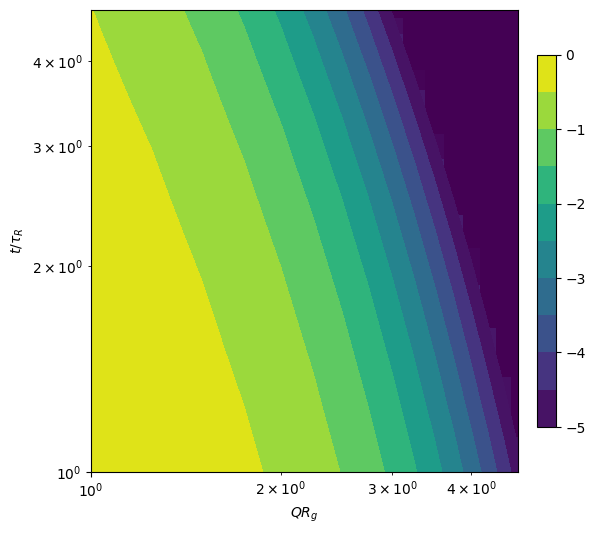

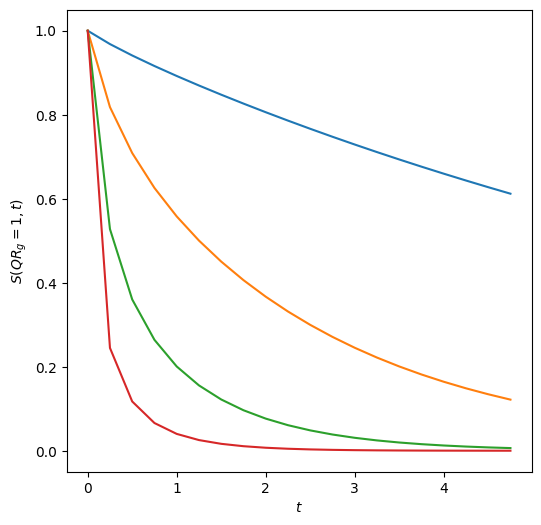

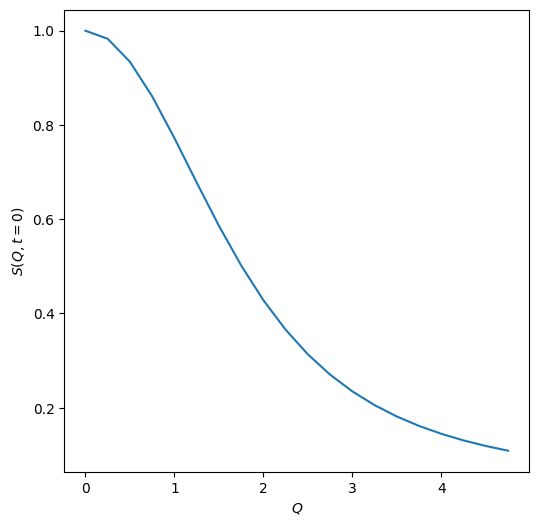

In [24]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
c = ax.pcolormesh(Q_grid, t_grid, np.log(sqt/sq0), cmap='viridis', vmax=0, vmin=-5) 
c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-5, 0, 11), cmap='viridis', vmax=0, vmin=-5)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04)
ax.set_xlim([1,6])
ax.set_ylim([1,10])
ax.set_xlabel(r'$QR_g$')
ax.set_ylabel(r'$t/\tau_R$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([np.min(QRg), np.max(QRg)])
ax.set_ylim([np.min(t), np.max(t)])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for q in [1,2,3,4]:
    ax.plot(t, (sqt/sq0)[:, np.argmin(np.abs(QRg - q))], label=r'$Q=0$')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S(QR_g=1,t)$')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(QRg, sq0)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$')
ax.set_ylabel(r'$S(Q,t=0)$')

## 3. Assign error bar

/tmp/ipykernel_3336720/1390360192.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim([np.min(t), np.max(t)])


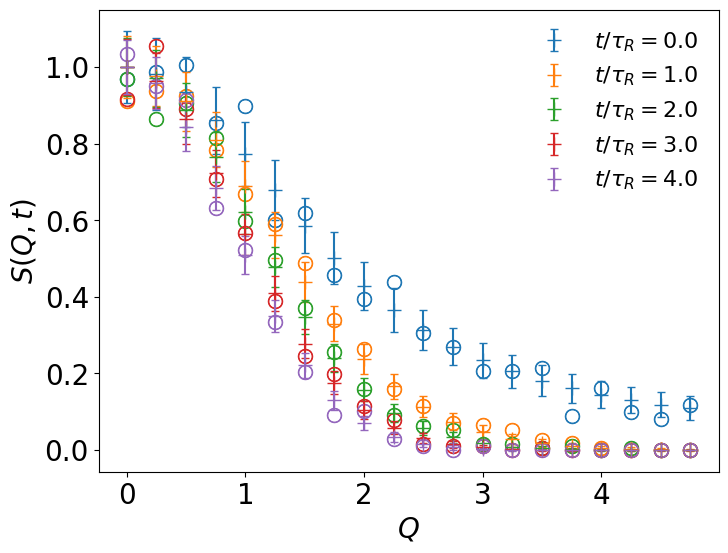

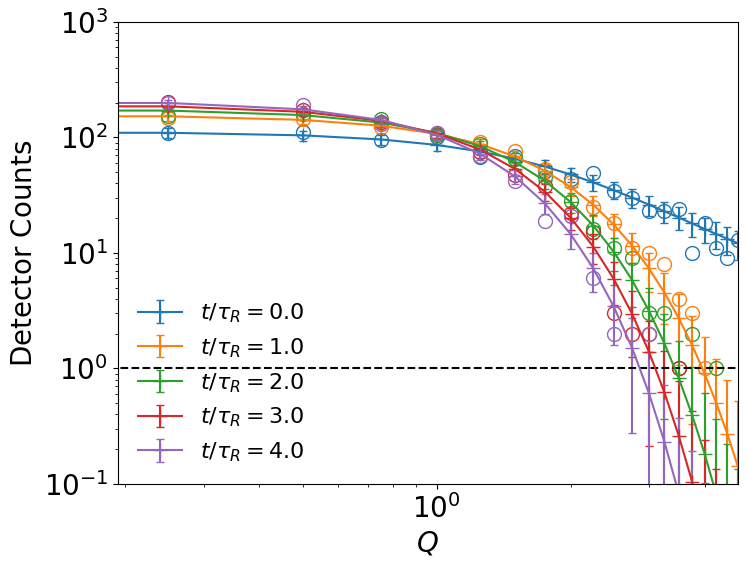

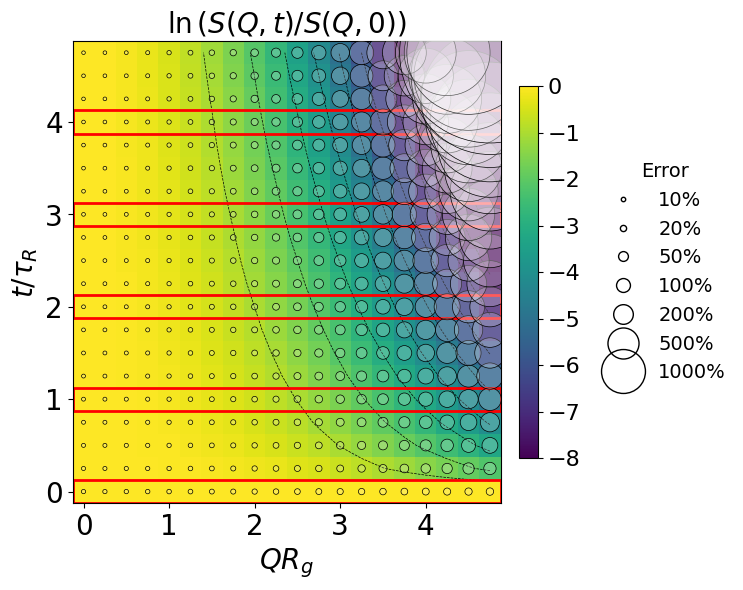

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

color_list = ['C0', 'C1', 'C2', 'C3', 'C4']
i_color=0

# fixed time
N_count = 1e3
Delta_sqt_Q = np.zeros((n_Q, n_t))
sqt_sample = np.zeros((n_Q, n_t))
for i in range(len(t)):
    fqi = sqt[i, :]
    pqi = fqi/np.sum(fqi)
    Nqi = N_count*pqi
    Delta_fqi = np.sqrt(Nqi)/N_count*np.sum(fqi)
    Delta_sqt_Q[i,:] = Delta_fqi
    
    bin_edges = np.linspace(0, len(Q), len(Q)+1)
    indices = np.random.choice(len(Q), size=int(N_count), p=pqi)
    N_sample_i, _ = np.histogram(indices, bins=bin_edges)
    sqt_sample_i = N_sample_i/N_count*np.sum(fqi)
    sqt_sample[i,:] = sqt_sample_i
    
    if t[i] in [0,1,2,3,4]:
        ax.errorbar(QRg, fqi, yerr=Delta_fqi, label=r'$t/\tau_R=%.1f$' % t[i], linestyle='none', capsize=3, color=color_list[i_color], marker='+', fillstyle='none', markersize=10)
        ax.plot(QRg, sqt_sample_i, 'o', color = color_list[i_color], fillstyle='none', linestyle='none', markersize=10)
        
        ax2.errorbar(QRg, Nqi, yerr=np.sqrt(Nqi), label=r'$t/\tau_R=%.1f$' % t[i], linestyle='-', capsize=3, color=color_list[i_color], marker='+', fillstyle='none', markersize=10)
        ax2.plot(QRg, N_sample_i, 'o', color = color_list[i_color], fillstyle='none', markersize=10)
        ax.plot(QRg, sqt_sample_i, 'o', color = color_list[i_color], fillstyle='none', markersize=10)
        i_color+=1
    
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$S(Q,t)$', fontsize=20)
ax.legend(frameon=False, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim([0.1, N_count])
ax2.plot([-1, np.max(t)*10], [1, 1], linestyle='--', color='k')
ax2.set_xlim([np.min(t), np.max(t)])
ax2.set_xlabel(r'$Q$', fontsize=20)
ax2.set_ylabel(r'$\mathrm{Detector\ Counts}$', fontsize=20)
ax2.legend(frameon=False, loc='lower left', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=20)

# Error wrt Q and t 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(Q_grid, t_grid, s=Delta_sqt_Q*100/sqt, edgecolors='k', linewidths=0.5, facecolors=[1,1,1,0.2], zorder=10)

# Create a legend for the scatter plot sizes with specific error values (%)
error_values = [10, 20, 50, 100, 200, 500, 1000]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=np.sqrt(ev), fillstyle='none', markeredgecolor='k') for ev in error_values]
labels = [f'{ev}%' for ev in error_values]
legend2 = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.2, 0.5), title="Error", title_fontsize=14, frameon=False, fontsize=14)

# c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
c = ax.pcolormesh(Q_grid, t_grid, np.log(sqt/sq0), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
ax.contour(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), zorder=-1, colors='k', linewidths=0.5)
ax.set_title(r'$\ln{(S(Q,t)/S(Q,0))}$', fontsize=20)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04).ax.tick_params(labelsize=16)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim([np.min(QRg), np.max(QRg)])
# ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)

# Plot rectangular boxes surrounding a stripe of given t, width equals t interval
dt = t[1] - t[0]
dQ = QRg[1] - QRg[0]
for t_value in [0, 1, 2, 3, 4]:
    ax.add_patch(plt.Rectangle((np.min(QRg) - dQ/2, t_value - dt/2), np.max(QRg) - np.min(QRg)+dQ, dt, 
                               edgecolor='r', facecolor='none', linestyle='-', linewidth=2))

/tmp/ipykernel_3336720/3451426825.py:47: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim([np.min(t), np.max(t)])


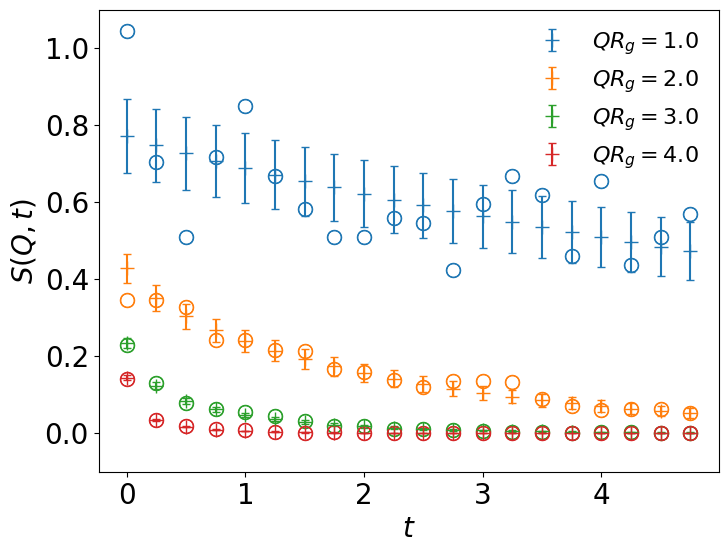

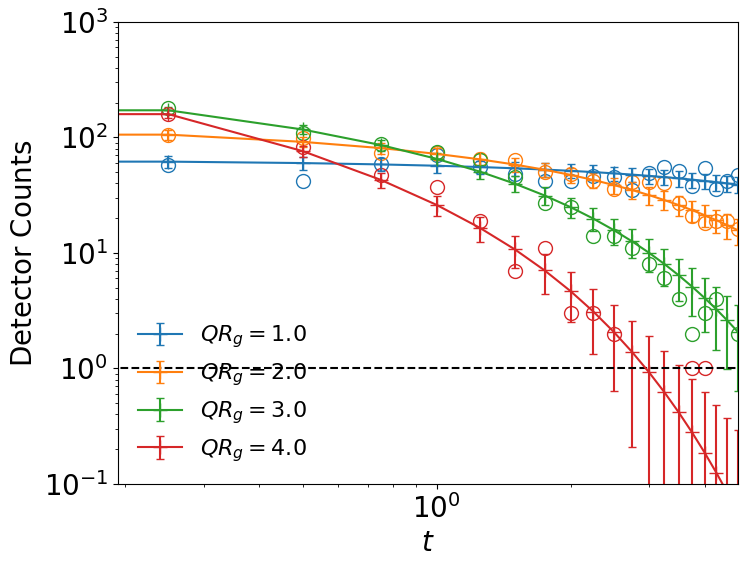

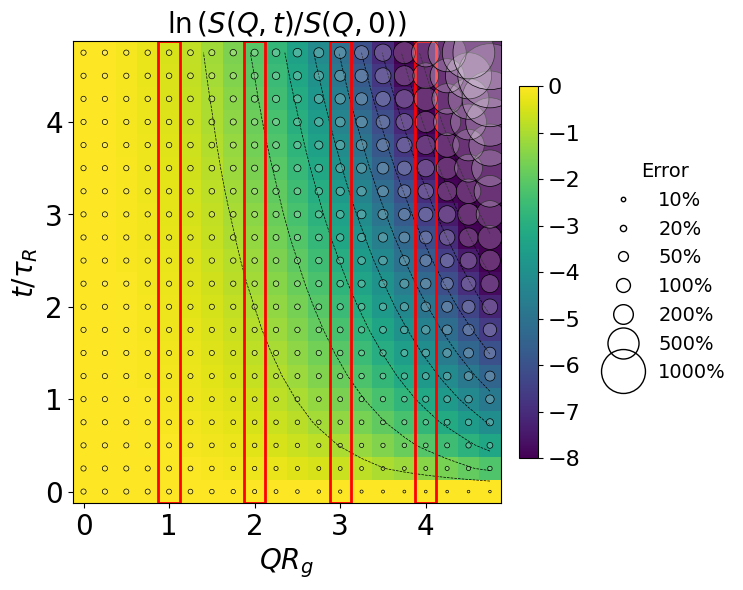

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

color_list = ['C0', 'C1', 'C2', 'C3', 'C4']
i_color=0

# fixed Q
N_count = 1e3
Delta_sqt_t = np.zeros((n_Q, n_t))
sqt_sample = np.zeros((n_Q, n_t))
for i in range(len(QRg)):
    fit = (sqt)[:,i]
    pit = fit/np.sum(fit)
    Nit = N_count*pit
    Delta_fit = np.sqrt(Nit)/N_count*np.sum(fit)
    Delta_sqt_t[:,i] = Delta_fit
    
    bin_edges = np.linspace(0, len(t), len(t)+1)
    indices = np.random.choice(len(t), size=int(N_count), p=pit)
    N_sample_i, _ = np.histogram(indices, bins=bin_edges)
    sqt_sample_i = N_sample_i/N_count*np.sum(fit)
    sqt_sample[:,i] = sqt_sample_i
    
    if QRg[i] in [1,2,3,4]:
        ax.errorbar(t, fit, yerr=Delta_fit, label=r'$QR_g=%.1f$' % QRg[i], linestyle='none', capsize=3, color=color_list[i_color], marker='+', fillstyle='none', markersize=10)
        ax.plot(t, sqt_sample_i, 'o', color = color_list[i_color], fillstyle='none', linestyle='none', markersize=10)
        
        ax2.errorbar(t, Nit, yerr=np.sqrt(Nit), label=r'$QR_g=%.1f$' % QRg[i], linestyle='-', capsize=3, color=color_list[i_color], marker='+', fillstyle='none', markersize=10)
        ax2.plot(t, N_sample_i, 'o', color = color_list[i_color], fillstyle='none', markersize=10)
        ax.plot(t, sqt_sample_i, 'o', color = color_list[i_color], fillstyle='none', markersize=10)
        i_color+=1
    
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$S(Q,t)$', fontsize=20)
ax.legend(frameon=False, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([-0.1, 1.1])

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim([0.1, N_count])
ax2.plot([-1, np.max(t)*10], [1, 1], linestyle='--', color='k')
ax2.set_xlim([np.min(t), np.max(t)])
ax2.set_xlabel(r'$t$', fontsize=20)
ax2.set_ylabel(r'$\mathrm{Detector\ Counts}$', fontsize=20)
ax2.legend(frameon=False, loc='lower left', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=20)

# Error wrt Q and t 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(Q_grid, t_grid, s=Delta_sqt_t*100/sqt, edgecolors='k', linewidths=0.5, facecolors=[1,1,1,0.2], zorder=10)

# Create a legend for the scatter plot sizes with specific error values (%)
error_values = [10, 20, 50, 100, 200, 500, 1000]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=np.sqrt(ev), fillstyle='none', markeredgecolor='k') for ev in error_values]
labels = [f'{ev}%' for ev in error_values]
legend2 = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.2, 0.5), title="Error", title_fontsize=14, frameon=False, fontsize=14)

# c = ax.contourf(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
c = ax.pcolormesh(Q_grid, t_grid, np.log(sqt/sq0), cmap='viridis', vmax=0, vmin=-8, zorder=-2)
ax.contour(Q_grid, t_grid, np.log(sqt/sq0), levels=np.linspace(-9, 0, 10), zorder=-1, colors='k', linewidths=0.5)
ax.set_title(r'$\ln{(S(Q,t)/S(Q,0))}$', fontsize=20)
fig.colorbar(c, ax=ax, fraction=0.04, pad=0.04).ax.tick_params(labelsize=16)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim([np.min(QRg), np.max(QRg)])
# ax.set_ylim([np.min(t), np.max(t)])
ax.tick_params(axis='both', which='major', labelsize=20)

# Plot rectangular boxes surrounding a stripe of given t, width equals t interval
dt = t[1] - t[0]
dQ = QRg[1] - QRg[0]
for Q_value in [1, 2, 3, 4]:
    ax.add_patch(plt.Rectangle((Q_value - dQ/2, np.min(t) - dt/2), dQ, np.max(t) - np.min(t)+dt, 
                               edgecolor='r', facecolor='none', linestyle='-', linewidth=2))

## 4. Test stretched exponential fit using linear algebra

In [27]:
# Define the stretched exponential function
def f_sexp(t, s0, tau, beta):
    return s0 * np.exp(- (t / tau) ** beta)

/tmp/ipykernel_3336720/2945295429.py:39: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  beta_fit = fsolve(equations, b_initial_guess)[0]  # Solve numerically


(-0.1, 1.1)

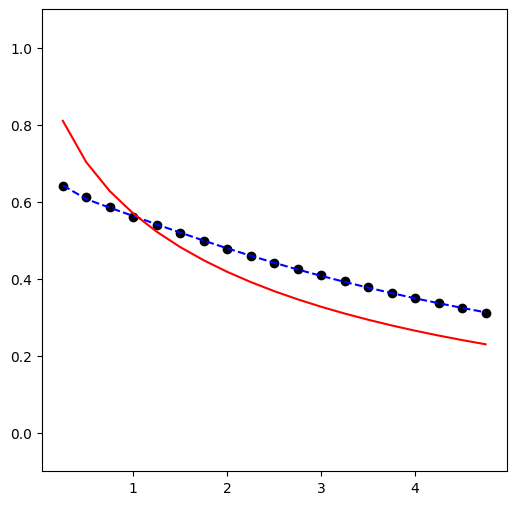

In [28]:
st_test = sqt[:,5]
s0_test = st_test[0]

# Ensure `t` is correctly filtered
valid_mask = t > 0  # Boolean mask
t_valid = t[valid_mask]  # Filter only valid t values
st_valid = st_test[valid_mask]  # Corresponding s(t) values

# Compute transformed variables
Y = np.log(st_valid)  # Target variable
X1 = np.log(t_valid)
X2 = X1**2
X3 = X1**3

# Feature matrix with higher-order terms
X = np.column_stack((np.ones_like(t_valid), X1, X2, X3))

# Solve Y = AX using least squares
A = np.linalg.lstsq(X, Y, rcond=None)[0]

# Extract coefficients
A0, A1, A2, A3 = A  # A3 is the cubic term coefficient

# # Compute β (beta) using the cubic coefficient
# beta_fit = (-6 * A3) ** (1 / 3)  # Ensure no complex numbers

# # Compute tau using the quadratic coefficient
# ln_tau_fit = (2 * A2 + beta_fit**2) / beta_fit**3
# tau_fit = np.exp(ln_tau_fit)  # Convert from log-space

# Define function to solve for b
def equations(b):
    b3 = b**3
    ln_tau = (2 * A2 + b**2) / b3
    return A1 + b - (b**2 * ln_tau) + (b3 / 2) * (ln_tau**2)

# Solve for beta (b) numerically
b_initial_guess = (-6 * A3) ** (1/3)  # Initial estimate
beta_fit = fsolve(equations, b_initial_guess)[0]  # Solve numerically

# Compute ln(tau) using the solved beta
ln_tau_fit = (2 * A2 + beta_fit**2) / beta_fit**3
tau_fit = np.exp(ln_tau_fit)  # Convert from log-space

# Compute s0 using the constant term
ln_s0_fit = A0 + 1 - beta_fit * ln_tau_fit + (beta_fit**2 / 2) * (ln_tau_fit**2)
s0_fit = np.exp(ln_s0_fit)  # Convert from log-space

# Generate fitted s(t) values
st_exp_fit = s0_fit * np.exp(- (t_valid / tau_fit) ** beta_fit)

st_poly_fit = np.exp(A0 + A1 * X1 + A2 * X1**2 + A3 * X1**3)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.scatter(t_valid, st_valid, label="Original Data", color="black", marker="o")
ax.plot(t_valid, st_poly_fit, label="Polynomial Fit", linestyle="dashed", color="blue")
ax.plot(t_valid, st_exp_fit, label="Stretched Exponential Fit", linestyle="solid", color="red")
ax.set_ylim([-0.1,1.1])
